# Master jupyter notebook for LANL - SlimBros Team

Correctly predicting earthquakes is very important for preventing deaths and damage to infrastructure. In this competition we try to predict time left to the next laboratory earthquake based on seismic signal data. Training data represents one huge signal, but in test data we have many separate chunks, for each of which we need to predict time to failure.

## Preliminaries
Let's import everything we need:

In [2]:
import os
import gc
import eli5
import csv
import dill
import time
import json
import random
import datetime
import warnings
import feather

import numpy as np
import pandas as pd
import altair as alt
import xgboost as xgb
import seaborn as sns
import lightgbm as lgb
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.display import HTML
from tqdm import tqdm_notebook
from altair.vega import v3
from catboost import CatBoostRegressor
from sklearn import svm, neighbors, linear_model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import NuSVR, SVR
from sklearn.neighbors import NearestNeighbors
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GridSearchCV, cross_val_score, ParameterGrid, train_test_split
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
from utils import generate_segment_start_ids, compare_methods
from features import gpi, create_all_features_extended
from features import gpi_new, gpii_new, gpiii_new
from features import gpi_tiny, gpii_tiny

#Configure the environment
%matplotlib inline
pd.options.display.precision = 15
warnings.filterwarnings('ignore')
random.seed(1013)

In [3]:
# Preparing altair. I use code from this great kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v3.SCHEMA_VERSION
vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
noext = "?noext"

paths = {
    'vega': vega_url + noext,
    'vega-lib': vega_lib_url + noext,
    'vega-lite': vega_lite_url + noext,
    'vega-embed': vega_embed_url + noext
}

workaround = """
requirejs.config({{
    baseUrl: 'https://cdn.jsdelivr.net/npm/',
    paths: {}
}});
"""

#------------------------------------------------ Defs for future rendering
def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
            
@add_autoincrement
def render(chart, id="vega-chart"):
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

HTML("".join((
    "<script>",
    workaround.format(json.dumps(paths)),
    "</script>",
)))

Load/compute the necessary features

In [2]:
compute_features = False 
# The computed features are saved in an hdf file along with the time_to_failure to 
# save the time spend reading the training data and the feature computation
#train_data_format = 'csv'
train_data_format = 'feather'

## Training data

In [3]:
def load_train_data(file_format):
    """Loads the training dataset."""
    print(f'Loading data from {file_format} file:', end="")
    if file_format.lower() == 'feather':
        train_df = feather.read_dataframe('../input/train.feather')
    else:
        train_df = pd.read_csv('../input/train.csv', dtype={'acoustic_data': np.int16,
                                                            'time_to_failure': np.float32})
        feather.write_dataframe(train_df, '../input/train.feather')
    print("Done")
    return train_df

In [4]:
train = load_train_data(train_data_format)

Loading data from feather file:Done


In [5]:
time_to_failure_delta = np.diff(train['time_to_failure'])
init_times = np.where(time_to_failure_delta > 5)[0].tolist()
print(f'There are {len(init_times)} quakes on the training set.')

There are 16 quakes on the training set.


## Feature generation
- Usual aggregations: mean, std, min and max;
- Average difference between the consequitive values in absolute and percent values;
- Absolute min and max vallues;
- Aforementioned aggregations for first and last 10000 and 50000 values - I think these data should be useful;
- Max value to min value and their differencem also count of values bigger that 500 (arbitrary threshold);
- Quantile features from this kernel: https://www.kaggle.com/andrekos/basic-feature-benchmark-with-quantiles
- Trend features from this kernel: https://www.kaggle.com/jsaguiar/baseline-with-abs-and-trend-features
- Rolling features from this kernel: https://www.kaggle.com/wimwim/rolling-quantiles

In [6]:
#features_version = ''
#features_version = 'v2'
features_version = 'v3'

In [7]:
saved_files_present = (os.path.isfile(f'../tmp_results/X{features_version}_tr.hdf') and 
                       os.path.isfile(f'../tmp_results/X{features_version}_test.hdf') and 
                       os.path.isfile(f'../tmp_results/y{features_version}_tr.hdf') )

In [8]:
if saved_files_present:
    print(f'The files containing the features ({features_version}) already exist.')
else:
    print(f'The files containing the features ({features_version}) do not exist')
    print(f'In the following step, the features will be computed. This may take several hours.')

The files containing the features (v3) already exist.


In [9]:
if (not compute_features) and saved_files_present:
    print(f'Reading hdf files ({features_version}): ', end="")
    X_tr = pd.read_hdf(f'../tmp_results/X{features_version}_tr.hdf', 'data')
    X_test = pd.read_hdf(f'../tmp_results/X{features_version}_test.hdf', 'data')
    y_tr = pd.read_hdf(f'../tmp_results/y{features_version}_tr.hdf', 'data')  
    print("Done")
else:
    fs = 4000000 #Sampling frequency of the raw signal

    #Compute features for the training data
    segment_size = 150000
    segment_start_ids = generate_segment_start_ids('uniform_no_jump', segment_size, train)
    X_tr = pd.DataFrame(index=range(len(segment_start_ids)), dtype=np.float64)
    y_tr = pd.DataFrame(index=range(len(segment_start_ids)), dtype=np.float64, columns=['time_to_failure'])
    for idx in tqdm_notebook(range(len(segment_start_ids))):        
        seg_id = segment_start_ids[idx]
        seg = train.iloc[seg_id:seg_id + segment_size]
        create_all_features_extended(idx, seg, X_tr, fs)
        y_tr.loc[idx, 'time_to_failure'] = seg['time_to_failure'].values[-1]
    # Sanity check
    means_dict = {}
    for col in X_tr.columns:
        if X_tr[col].isnull().any():
            print(col)
            mean_value = X_tr.loc[X_tr[col] != -np.inf, col].mean()
            X_tr.loc[X_tr[col] == -np.inf, col] = mean_value
            X_tr[col] = X_tr[col].fillna(mean_value)
            means_dict[col] = mean_value

    #Compute features for the test data
    submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
    X_test = pd.DataFrame(columns=X_tr.columns, dtype=np.float64, index=submission.index)
    for i, seg_id in enumerate(tqdm_notebook(X_test.index)):
        seg = pd.read_csv('../input/test/' + seg_id + '.csv')
        create_all_features_extended(seg_id, seg, X_test, fs)

    # Sanity check
    for col in X_test.columns:
        if X_test[col].isnull().any():
            X_test.loc[X_test[col] == -np.inf, col] = means_dict[col]
            X_test[col] = X_test[col].fillna(means_dict[col])
            
    X_tr.to_hdf(f'../tmp_results/X{features_version}_tr.hdf', 'data')
    X_test.to_hdf(f'../tmp_results/X{features_version}_test.hdf', 'data')
    y_tr.to_hdf(f'../tmp_results/y{features_version}_tr.hdf', 'data')
    
    del segment_start_ids
    del means_dict
    del submission
    
    print("Done")

Reading hdf files (v3): Done


## Scale data

In [10]:
alldata = pd.concat([X_tr, X_test])
scaler = StandardScaler()
alldata = pd.DataFrame(scaler.fit_transform(alldata), columns=alldata.columns)
X_train_scaled = alldata[:X_tr.shape[0]]
X_test_scaled = alldata[X_tr.shape[0]:]

## Building models

In [47]:
def train_model(X, X_test, y, folds, params=None, model_type='lgb',
                model=None, show_scatter=False, force_positive=False, compute_feature_importance=True):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    n_fold = folds.get_n_splits()
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())

        if type(X) == np.ndarray:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
           
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                      eval_set=[(X_train, y_train), (X_valid, y_valid)],
                      eval_metric='mae',
                      verbose=0,
                      early_stopping_rounds=2000)
            
            y_pred_valid = model.predict(X_valid)
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
          
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data,
                              num_boost_round=20000,
                              evals=watchlist,
                              early_stopping_rounds=200,
                              verbose_eval=0,
                              params=params)

            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns),
                                         ntree_limit=model.best_ntree_limit)
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
          
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns),
                                   ntree_limit=model.best_ntree_limit)
        
        if model_type == 'gpi':
            y_pred_valid = gpi(X_valid, activation=params['activation']).values
            y_pred = gpi(X_test, activation=params['activation']).values
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)

        if model_type == 'gpi_new':
            y_pred_valid = gpi_new(X_valid, activation=params['activation']).values
            y_pred = gpi_new(X_test, activation=params['activation']).values
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
            
        if model_type == 'gpii_new':
            y_pred_valid = gpii_new(X_valid, activation=params['activation']).values
            y_pred = gpii_new(X_test, activation=params['activation']).values
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
                
        if model_type == 'gpiii_new':
            y_pred_valid = gpiii_new(X_valid, activation=params['activation']).values
            y_pred = gpiii_new(X_test, activation=params['activation']).values
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
                
        if model_type == 'gpi_tiny':
            y_pred_valid = gpi_tiny(X_valid, activation=params['activation']).values
            y_pred = gpi_tiny(X_test, activation=params['activation']).values
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
                
        if model_type == 'gpii_tiny':
            y_pred_valid = gpii_tiny(X_valid, activation=params['activation']).values
            y_pred = gpii_tiny(X_test, activation=params['activation']).values
            if force_positive:
                y_pred_valid = y_pred_valid.clip(min=0)
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))
        
        prediction += y_pred    
        
        if model_type == 'lgb' and compute_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance['feature'] = X.columns
            fold_importance['importance'] = model.feature_importances_
            fold_importance['fold'] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    if force_positive:
        prediction = prediction.clip(min=0)    
    
    if show_scatter:
        fig, axis = plt.subplots(1, 2, figsize=(12,5))
        ax1, ax2 = axis
        ax1.set_xlabel('actual')
        ax1.set_ylabel('predicted')
        ax2.set_xlabel('train index')
        ax2.set_ylabel('time to failure')
        
        ax1.scatter(y, oof, color='brown')
        ax1.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)], color='blue')

        ax2.plot(y, color='blue', label='y_train')
        ax2.plot(oof, color='orange')
    
    print(f'CV mean score: {np.mean(scores):.4f}, std: {np.std(scores):.4f}.')
    
    if model_type == 'lgb' and compute_feature_importance:
        feature_importance['importance'] /= n_fold
        return oof, prediction, scores, feature_importance
    else:
        return oof, prediction, scores

In [12]:
n_fold = 5
folds_models = KFold(n_splits=n_fold, shuffle=True, random_state=13)

Let's try a few different models and submit the one with the best validation score. The predicted values in the following plots are using a out-of-fold scheme.

### LGBM (Gradient Boosting)

In [13]:
#TODO: optimize params
params_lgb = {
    'objective': 'huber',
    'boosting': 'gbdt',
    'verbosity': -1,
    'num_leaves': 12,
    'min_data_in_leaf': 40,
    'max_depth': 8,
    'learning_rate': 0.005,
    'bagging_freq': 4,
    'bagging_fraction': 0.6,
    'bagging_seed': 11,
    'random_seed': 19,
    'metric': 'mae',
    'reg_alpha': 0.47777777777777775,
    'reg_lambda': 0.47777777777777775
}

In [14]:
oof_lgb, prediction_lgb, scores_lgb, feature_importance_lgb = train_model(X=X_train_scaled,
                                                                          X_test=X_test_scaled,
                                                                          y=y_tr,
                                                                          folds=folds_models,
                                                                          params=params_lgb,
                                                                          model_type='lgb')

Fold 0 started at Sun May 12 15:02:32 2019
Fold 1 started at Sun May 12 15:03:37 2019
Fold 2 started at Sun May 12 15:04:52 2019
Fold 3 started at Sun May 12 15:06:38 2019
Fold 4 started at Sun May 12 15:07:50 2019
CV mean score: 2.0049, std: 0.0780.


### XGBoost (Gradient Boosting)

In [15]:
#TODO: optimize params
params_xgb = {
    'eta': 0.01,
    'max_depth': 6,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'eval_metric': 'mae',
    'silent': True,
    'nthread': 32
}
oof_xgb, prediction_xgb, scores_xgb = train_model(X=X_train_scaled,
                                                  X_test=X_test_scaled,
                                                  y=y_tr,
                                                  folds=folds_models,
                                                  params=params_xgb,
                                                  model_type='xgb')

Fold 0 started at Sun May 12 15:10:04 2019
Fold 1 started at Sun May 12 15:10:15 2019
Fold 2 started at Sun May 12 15:10:27 2019
Fold 3 started at Sun May 12 15:10:39 2019
Fold 4 started at Sun May 12 15:10:51 2019
CV mean score: 2.0066, std: 0.0778.


### Genetic Program Models (borrowed from Kaggle)

In [16]:
params_gpi = {
    'activation':'atan'
}
oof_gpi, prediction_gpi, scores_gpi = train_model(X=X_train_scaled,
                                                  X_test=X_test_scaled,
                                                  y=y_tr,
                                                  folds=folds_models,
                                                  params=params_gpi,
                                                  model_type='gpi')

Fold 0 started at Sun May 12 15:11:03 2019
Fold 1 started at Sun May 12 15:11:04 2019
Fold 2 started at Sun May 12 15:11:05 2019
Fold 3 started at Sun May 12 15:11:06 2019
Fold 4 started at Sun May 12 15:11:07 2019
CV mean score: 1.9140, std: 0.0853.


In [17]:
params_gpi_new = {
    'activation':'atan'
}
oof_gpi_new, prediction_gpi_new, scores_gpi_new = train_model(X=X_train_scaled,
                                                              X_test=X_test_scaled,
                                                              y=y_tr,
                                                              folds=folds_models,
                                                              params=params_gpi_new,
                                                              model_type='gpi_new')

Fold 0 started at Sun May 12 15:11:08 2019
Fold 1 started at Sun May 12 15:11:08 2019
Fold 2 started at Sun May 12 15:11:09 2019
Fold 3 started at Sun May 12 15:11:10 2019
Fold 4 started at Sun May 12 15:11:10 2019
CV mean score: 1.9543, std: 0.0955.


In [18]:
params_gpii_new = {
    'activation':'atan'
}
oof_gpii_new, prediction_gpii_new, scores_gpii_new = train_model(X=X_train_scaled,
                                                                 X_test=X_test_scaled,
                                                                 y=y_tr,
                                                                 folds=folds_models,
                                                                 params=params_gpii_new,
                                                                 model_type='gpii_new')

Fold 0 started at Sun May 12 15:11:11 2019
Fold 1 started at Sun May 12 15:11:12 2019
Fold 2 started at Sun May 12 15:11:12 2019
Fold 3 started at Sun May 12 15:11:13 2019
Fold 4 started at Sun May 12 15:11:14 2019
CV mean score: 1.9698, std: 0.0927.


In [19]:
params_gpiii_new = {
    'activation':'atan'
}
oof_gpiii_new, prediction_gpiii_new, scores_gpiii_new = train_model(X=X_train_scaled,
                                                                    X_test=X_test_scaled,
                                                                    y=y_tr,
                                                                    folds=folds_models,
                                                                    params=params_gpiii_new,
                                                                    model_type='gpiii_new')

Fold 0 started at Sun May 12 15:11:14 2019
Fold 1 started at Sun May 12 15:11:15 2019
Fold 2 started at Sun May 12 15:11:16 2019
Fold 3 started at Sun May 12 15:11:16 2019
Fold 4 started at Sun May 12 15:11:17 2019
CV mean score: 1.9563, std: 0.0912.


In [20]:
params_gpi_tiny = {
    'activation':'atan'
}
oof_gpi_tiny, prediction_gpi_tiny, scores_gpi_tiny = train_model(X=X_train_scaled,
                                                                 X_test=X_test_scaled,
                                                                 y=y_tr,
                                                                 params=params_gpi_tiny,
                                                                 folds=folds_models,
                                                                 model_type='gpi_tiny')

Fold 0 started at Sun May 12 15:11:18 2019
Fold 1 started at Sun May 12 15:11:18 2019
Fold 2 started at Sun May 12 15:11:18 2019
Fold 3 started at Sun May 12 15:11:18 2019
Fold 4 started at Sun May 12 15:11:18 2019
CV mean score: 2.2715, std: 0.0715.


In [21]:
params_gpii_tiny = {
    'activation':'atan'
}
oof_gpii_tiny, prediction_gpii_tiny, scores_gpii_tiny = train_model(X=X_train_scaled,
                                                                    X_test=X_test_scaled,
                                                                    y=y_tr,
                                                                    params=params_gpii_tiny,
                                                                    folds=folds_models,
                                                                    model_type='gpii_tiny')

Fold 0 started at Sun May 12 15:11:18 2019
Fold 1 started at Sun May 12 15:11:18 2019
Fold 2 started at Sun May 12 15:11:18 2019
Fold 3 started at Sun May 12 15:11:18 2019
Fold 4 started at Sun May 12 15:11:18 2019
CV mean score: 2.3044, std: 0.0587.


# Compare models

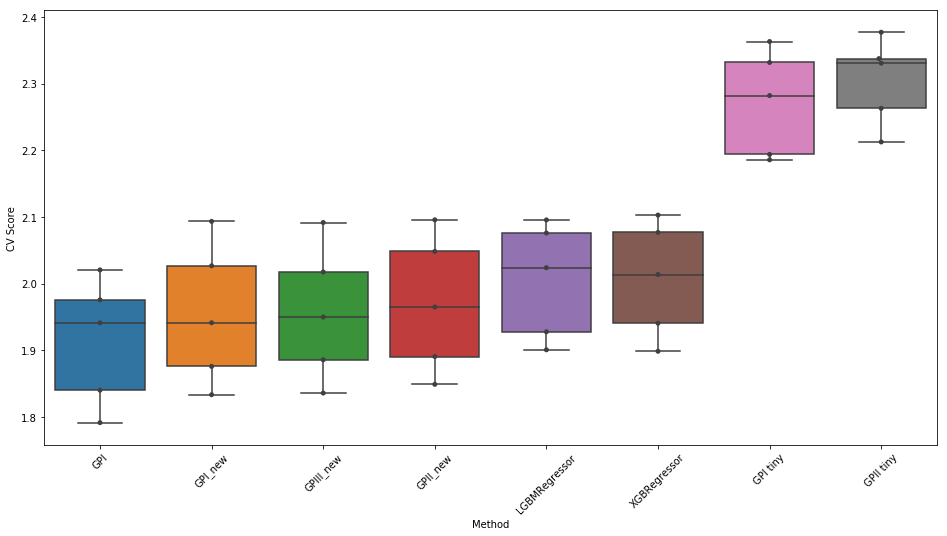

In [22]:
plt.figure(figsize=(16, 8));
scores_df = pd.DataFrame()
try:
    scores_df['LGBMRegressor'] = scores_lgb
except NameError:
    print('LGBMRegressor not computed')
try:
    scores_df['XGBRegressor'] = scores_xgb
except NameError:
    print('XGBRegressor not computed')
try:
    scores_df['GPI'] = scores_gpi
except NameError:
    print('GPI not computed')
try:
    scores_df['GPI_new'] = scores_gpi_new
except NameError:
    print('GPI_new not computed')
try:
    scores_df['GPII_new'] = scores_gpii_new
except NameError:
    print('GPII_new not computed')    
try:
    scores_df['GPIII_new'] = scores_gpiii_new
except NameError:
    print('GPIII_new not computed')     
try:
    scores_df['GPI tiny'] = scores_gpi_tiny
except NameError:
    print('GPI tiny not computed')
try:
    scores_df['GPII tiny'] = scores_gpii_tiny
except NameError:
    print('GPII tiny not computed')
    
ax = sns.boxplot(data=scores_df.reindex(scores_df.mean().sort_values().index, axis=1));
ax = sns.swarmplot(data=scores_df.reindex(scores_df.mean().sort_values().index, axis=1), color=".25")
#ax.set(yscale="log")

plt.xticks(rotation=45);
plt.xlabel('Method');
plt.ylabel('CV Score');

In [3]:
#dill.dump_session('notebook_env.db')
dill.load_session('notebook_env.db')

## Feature reduction

### ELI5 and permutation importance
ELI5 is a package with provides explanations for ML models. It can do this not only for linear models, but also for tree based like Random Forest or lightgbm.

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_scaled, y_tr, test_size=0.2)
model = lgb.LGBMRegressor(**params_lgb, n_estimators = 50000, n_jobs = -1, verbose=-1)
model.fit(X_train,
          y_train, 
          eval_set=[(X_train, y_train), (X_valid, y_valid)],
          eval_metric='mae',
          verbose=10000,
          early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[2364]	training's l1: 1.6113	valid_1's l1: 2.0918


LGBMRegressor(bagging_fraction=0.6, bagging_freq=4, bagging_seed=11,
       boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=1.0, importance_type='split', learning_rate=0.005,
       max_depth=8, metric='mae', min_child_samples=20,
       min_child_weight=0.001, min_data_in_leaf=40, min_split_gain=0.0,
       n_estimators=50000, n_jobs=-1, num_leaves=12, objective='huber',
       random_seed=19, random_state=None, reg_alpha=0.47777777777777775,
       reg_lambda=0.47777777777777775, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0, verbose=-1,
       verbosity=-1)

In [8]:
perm = eli5.sklearn.PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, top=50, feature_names=X_train_scaled.columns.values.tolist())

Weight,Feature
0.0099 ± 0.0014,percentile_roll_std_5_window_50
0.0096 ± 0.0031,iqr_6
0.0085 ± 0.0016,percentile_roll_std_10_window_1000
0.0082 ± 0.0022,abs_q05_5
0.0081 ± 0.0017,percentile_roll_std_10_window_500
0.0069 ± 0.0011,abs_q01_4
0.0064 ± 0.0017,percentile_roll_std_5_window_10
0.0063 ± 0.0011,abs_q01_5
0.0060 ± 0.0013,percentile_roll_std_25_window_500
0.0059 ± 0.0010,percentile_roll_std_20_window_1000


In [13]:
top_num_features = 40
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:top_num_features]
oof_lgb_top, prediction_lgb_top, scores_lgb_top, feature_importance_lgb_top = train_model(
    X=X_train_scaled[top_features],
    X_test=X_test_scaled[top_features],
    y=y_tr,
    folds=folds_models,
    params=params_lgb,
    model_type='lgb',
    show_scatter=False)

Fold 0 started at Sun May 12 19:28:33 2019
Fold 1 started at Sun May 12 19:28:37 2019
Fold 2 started at Sun May 12 19:28:41 2019
Fold 3 started at Sun May 12 19:28:45 2019
Fold 4 started at Sun May 12 19:28:49 2019
CV mean score: 2.0238, std: 0.0840.


### SelectPercentile

In [70]:
#params_lgb_sp = {'num_leaves': 32,
#                 'min_child_samples': 79,
#                 'objective': 'gamma',
#                 'max_depth': -1,
#                 'learning_rate': 0.01,
#                 "boosting_type": "gbdt",
#                 "subsample_freq": 5,
#                 "subsample": 0.9,
#                 "bagging_seed": 11,
#                 "metric": 'mae',
#                 "verbosity": -1,
#                 'reg_alpha': 0.1302650970728192,
#                 'reg_lambda': 0.3603427518866501,
#                 'colsample_bytree': 1.0
#}
#scores_dict = {'f_classif': [], 'mutual_info_classif': [], 'n_features': []}
#for i in tqdm_notebook(range(5, 100, 4)):
#    s1 = SelectPercentile(f_classif, percentile=i)
#    X_train1 = s1.fit_transform(X_train_scaled, y_tr.values.astype(int))
#    X_test1 = s1.transform(X_test_scaled)
#    oof, prediction, scores = train_model(X=X_train1,
#                                          X_test=X_test1,
#                                          y=y_tr.values.reshape(-1, ),
#                                          params=params_lgb_sp,
#                                          folds=folds_models,
#                                          model_type='lgb',
#                                          compute_feature_importance=False)
#
#    scores_dict['f_classif'].append(np.mean(scores))
#
#    s2 = SelectPercentile(mutual_info_classif, percentile=i)
#    X_train1 = s2.fit_transform(X_train_scaled, y_tr.values.astype(int))
#    X_test1 = s2.transform(X_test_scaled)
#    oof, prediction, scores = train_model(X=X_train1,
#                                          X_test=X_test1,
#                                          y=y_tr.values.reshape(-1, ),
#                                          params=params_lgb_sp,
#                                          folds=folds_models,
#                                          model_type='lgb',
#                                          compute_feature_importance=False)
#    
#    scores_dict['mutual_info_classif'].append(np.mean(scores)) 
#    scores_dict['n_features'].append(X_train1.shape[1])

Fold 0 started at Sun May 12 22:49:09 2019
Fold 1 started at Sun May 12 22:49:15 2019
Fold 2 started at Sun May 12 22:49:21 2019
Fold 3 started at Sun May 12 22:49:26 2019
Fold 4 started at Sun May 12 22:49:31 2019
CV mean score: 2.0343, std: 0.0706.
Fold 0 started at Sun May 12 22:50:43 2019
Fold 1 started at Sun May 12 22:50:48 2019
Fold 2 started at Sun May 12 22:50:53 2019
Fold 3 started at Sun May 12 22:50:58 2019
Fold 4 started at Sun May 12 22:51:03 2019
CV mean score: 2.0297, std: 0.0689.
Fold 0 started at Sun May 12 22:51:08 2019
Fold 1 started at Sun May 12 22:51:16 2019
Fold 2 started at Sun May 12 22:51:23 2019
Fold 3 started at Sun May 12 22:51:30 2019
Fold 4 started at Sun May 12 22:51:37 2019
CV mean score: 2.0355, std: 0.0811.
Fold 0 started at Sun May 12 22:52:51 2019
Fold 1 started at Sun May 12 22:52:58 2019
Fold 2 started at Sun May 12 22:53:06 2019
Fold 3 started at Sun May 12 22:53:12 2019
Fold 4 started at Sun May 12 22:53:19 2019
CV mean score: 2.0365, std: 0.07

Fold 4 started at Mon May 13 00:18:45 2019
CV mean score: 2.0145, std: 0.0740.
Fold 0 started at Mon May 13 00:20:45 2019
Fold 1 started at Mon May 13 00:21:41 2019
Fold 2 started at Mon May 13 00:22:32 2019
Fold 3 started at Mon May 13 00:23:24 2019
Fold 4 started at Mon May 13 00:24:13 2019
CV mean score: 2.0174, std: 0.0789.
Fold 0 started at Mon May 13 00:25:08 2019
Fold 1 started at Mon May 13 00:26:07 2019
Fold 2 started at Mon May 13 00:27:03 2019
Fold 3 started at Mon May 13 00:27:58 2019
Fold 4 started at Mon May 13 00:28:51 2019
CV mean score: 2.0130, std: 0.0755.
Fold 0 started at Mon May 13 00:30:53 2019
Fold 1 started at Mon May 13 00:31:50 2019
Fold 2 started at Mon May 13 00:32:45 2019
Fold 3 started at Mon May 13 00:33:43 2019
Fold 4 started at Mon May 13 00:34:37 2019
CV mean score: 2.0154, std: 0.0797.
Fold 0 started at Mon May 13 00:35:33 2019
Fold 1 started at Mon May 13 00:36:34 2019
Fold 2 started at Mon May 13 00:37:31 2019
Fold 3 started at Mon May 13 00:38:29 2

In [80]:
#scores_dict

In [101]:
scores_dict = {'f_classif': [2.0343477795444036,
  2.0355455453136915,
  2.0232742681776292,
  2.0244063746070733,
  2.0232742948460425,
  2.019923671589739,
  2.018230702249711,
  2.020300747393173,
  2.0199075437249494,
  2.0171105490872003,
  2.0184329453523544,
  2.0174601542787545,
  2.018466211403575,
  2.0183167032445897,
  2.014248206030377,
  2.0141536426086946,
  2.014483471908119,
  2.013020226262407,
  2.014309362745986,
  2.0134798312418125,
  2.012349789136249,
  2.0165996821269125,
  2.018380871634508,
  2.018428372252885],
 'mutual_info_classif': [2.0297173285890175,
  2.036483879244638,
  2.0098340816140223,
  2.0107506210715784,
  2.011762456569545,
  2.0145003921151527,
  2.0126037584029537,
  2.013565103792627,
  2.02177352416549,
  2.0201674061774093,
  2.0229088331640535,
  2.021982325219455,
  2.0231823173584047,
  2.0232832071154654,
  2.0202198610545676,
  2.0199848253677617,
  2.0174156825631195,
  2.0153728721649946,
  2.017204124676203,
  2.0168609184991295,
  2.017899116095079,
  2.0205002533749825,
  2.0186892617425998,
  2.0232269839211687],
 'n_features': [116,
  208,
  300,
  392,
  485,
  577,
  668,
  761,
  853,
  946,
  1038,
  1130,
  1222,
  1314,
  1407,
  1499,
  1591,
  1683,
  1775,
  1868,
  1960,
  2052,
  2144,
  2236]}

In [102]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['mutual_info_classif', 'f_classif'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.01
min_value = scores_df['mae'].min() * 0.99
render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by SelectPercentile vs CV'
).interactive())

In [84]:
#dill.dump_session('notebook_env.db')
#dill.load_session('notebook_env.db')

In [96]:
#scores_dict = {'f_classif': [], 'mutual_info_classif': [], 'n_features': []}
#total_num_features = X_train_scaled.shape[1]
#for i in tqdm_notebook(np.arange(10, total_num_features, 200)):
#    s1 = SelectKBest(f_classif, k=i)
#    X_train1 = s1.fit_transform(X_train_scaled, y_tr.values.astype(int))
#    X_test1 = s1.transform(X_test_scaled)
#    oof, prediction, scores = train_model(X=X_train1,
#                                          X_test=X_test1,
#                                          y=y_tr.values.reshape(-1, ),
#                                          params=params_lgb_sp,
#                                          folds=folds_models,
#                                          model_type='lgb',
#                                          compute_feature_importance=False)
#    
#    
#    scores_dict['f_classif'].append(np.mean(scores))
#    
#    s2 = SelectKBest(mutual_info_classif, k=i)
#    X_train1 = s2.fit_transform(X_train_scaled, y_tr.values.astype(int))
#    X_test1 = s2.transform(X_test_scaled)
#    oof, prediction, scores = train_model(X=X_train1,
#                                          X_test=X_test1,
#                                          y=y_tr.values.reshape(-1, ),
#                                          params=params_lgb_sp,
#                                          folds=folds_models,
#                                          model_type='lgb',
#                                          compute_feature_importance=False)
#
#    scores_dict['mutual_info_classif'].append(np.mean(scores))
#    scores_dict['n_features'].append(X_train1.shape[1])

Fold 0 started at Mon May 13 10:57:15 2019
Fold 1 started at Mon May 13 10:57:18 2019
Fold 2 started at Mon May 13 10:57:21 2019
Fold 3 started at Mon May 13 10:57:24 2019
Fold 4 started at Mon May 13 10:57:27 2019
CV mean score: 2.0963, std: 0.0654.
Fold 0 started at Mon May 13 10:58:37 2019
Fold 1 started at Mon May 13 10:58:40 2019
Fold 2 started at Mon May 13 10:58:44 2019
Fold 3 started at Mon May 13 10:58:47 2019
Fold 4 started at Mon May 13 10:58:50 2019
CV mean score: 2.0818, std: 0.0707.
Fold 0 started at Mon May 13 10:58:54 2019
Fold 1 started at Mon May 13 10:59:02 2019
Fold 2 started at Mon May 13 10:59:10 2019
Fold 3 started at Mon May 13 10:59:17 2019
CV mean score: 2.0293, std: 0.0748.
Fold 0 started at Mon May 13 11:01:16 2019
Fold 1 started at Mon May 13 11:01:30 2019
Fold 2 started at Mon May 13 11:01:44 2019
Fold 3 started at Mon May 13 11:01:56 2019
Fold 4 started at Mon May 13 11:02:09 2019
CV mean score: 2.0221, std: 0.0797.
Fold 0 started at Mon May 13 11:03:28 2

In [97]:
scores_dict

{'f_classif': [2.096300133654597,
  2.035837476378528,
  2.022050251570348,
  2.0241298815371,
  2.02139866862493,
  2.0149855032259296,
  2.0143757190099865,
  2.0128268901461506,
  2.0145139926226454,
  2.011935364742608,
  2.0131685350751556,
  2.0203177000004793],
 'mutual_info_classif': [2.081830579441687,
  2.0292863861104946,
  2.0077596186341142,
  2.009608194200964,
  2.016935009456815,
  2.0207690688020232,
  2.0210419332588314,
  2.0197190156733,
  2.0171935341649085,
  2.0151143411269743,
  2.021664766223919,
  2.018440425130261],
 'n_features': [10,
  210,
  410,
  610,
  810,
  1010,
  1210,
  1410,
  1610,
  1810,
  2010,
  2210]}

In [98]:
scores_dict = {'f_classif': [2.096300133654597,
  2.035837476378528,
  2.022050251570348,
  2.0241298815371,
  2.02139866862493,
  2.0149855032259296,
  2.0143757190099865,
  2.0128268901461506,
  2.0145139926226454,
  2.011935364742608,
  2.0131685350751556,
  2.0203177000004793],
 'mutual_info_classif': [2.081830579441687,
  2.0292863861104946,
  2.0077596186341142,
  2.009608194200964,
  2.016935009456815,
  2.0207690688020232,
  2.0210419332588314,
  2.0197190156733,
  2.0171935341649085,
  2.0151143411269743,
  2.021664766223919,
  2.018440425130261],
 'n_features': [10,
  210,
  410,
  610,
  810,
  1010,
  1210,
  1410,
  1610,
  1810,
  2010,
  2210]}

In [100]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['mutual_info_classif', 'f_classif'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.01
min_value = scores_df['mae'].min() * 0.99
render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by SelectKBest vs CV'
).interactive())

### Dropping highly correlated features

Due to the huge number of features there are certainly some highly correlated features, let's try droping them!

In [103]:
X_train_scaled_uncorr = X_train_scaled.copy()
X_test_scaled_uncorr = X_test_scaled.copy()

In [104]:
# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
corr_matrix = X_train_scaled_uncorr.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.99
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
X_train_scaled_uncorr = X_train_scaled_uncorr.drop(to_drop, axis=1)
X_test_scaled_uncorr = X_test_scaled_uncorr.drop(to_drop, axis=1)

print(X_train_scaled.shape)
print(X_train_scaled_uncorr.shape)

(4178, 2306)
(4178, 1113)


Fold 0 started at Mon May 13 13:07:12 2019
Fold 1 started at Mon May 13 13:07:43 2019
Fold 2 started at Mon May 13 13:08:26 2019
Fold 3 started at Mon May 13 13:09:08 2019
Fold 4 started at Mon May 13 13:09:42 2019
CV mean score: 2.0148, std: 0.0757.


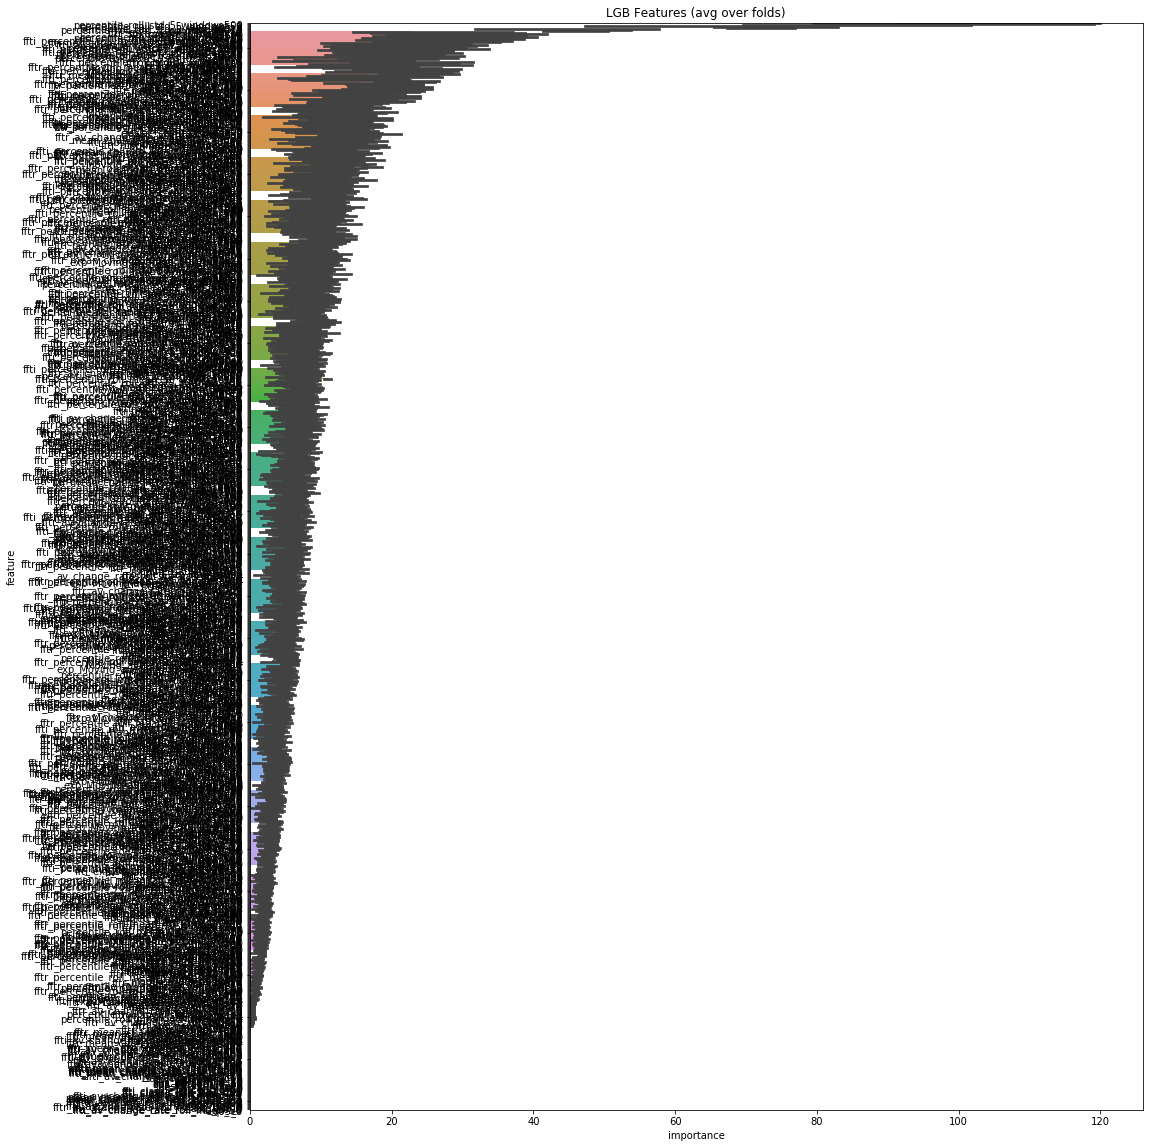

In [105]:
oof_lgb_uncorr, prediction_lgb_uncorr, scores_lgb_uncorr, feature_importance_lgb_uncorr = train_model(
    X=X_train_scaled_uncorr,
    X_test=X_test_scaled_uncorr,
    y=y_tr,
    folds=folds_models,
    params=params_lgb,
    model_type='lgb',
    show_scatter=False)
cols = feature_importance_lgb_uncorr[['feature', 'importance']].groupby('feature').mean().sort_values(
    by='importance', ascending=False).index
best_features = feature_importance_lgb_uncorr.loc[feature_importance_lgb_uncorr.feature.isin(cols)]
plt.figure(figsize=(16, 20));
sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False));
plt.title('LGB Features (avg over folds)');

### RFE (Feature ranking with recursive feature elimination)

In [8]:
scores_dict = {'rfe_score': [], 'n_features': []}
total_num_features = X_train_scaled_uncorr.shape[1]
for i in tqdm_notebook(np.arange(10, total_num_features, 100)):
    s1 = RFE(model, i, step=100)
    X_train1 = s1.fit_transform(X_train_scaled_uncorr, y_tr.values.astype(int))
    X_test1 = s1.transform(X_test_scaled_uncorr)    
    oof, prediction, scores = train_model(X=X_train1,
                                          X_test=X_test1,
                                          y=y_tr.values.reshape(-1, ),
                                          params=params_lgb_sp,
                                          folds=folds_models,
                                          model_type='lgb',
                                          compute_feature_importance=False)
    scores_dict['rfe_score'].append(np.mean(scores))    
    scores_dict['n_features'].append(X_train1.shape[1])

Fold 0 started at Tue May 14 09:45:19 2019
Fold 1 started at Tue May 14 09:45:22 2019
Fold 2 started at Tue May 14 09:45:26 2019
Fold 3 started at Tue May 14 09:45:29 2019
Fold 4 started at Tue May 14 09:45:33 2019
CV mean score: 2.6171, std: 0.0644.
Fold 0 started at Tue May 14 10:20:27 2019
Fold 1 started at Tue May 14 10:20:32 2019
Fold 2 started at Tue May 14 10:20:37 2019
Fold 3 started at Tue May 14 10:20:43 2019
Fold 4 started at Tue May 14 10:20:48 2019
CV mean score: 2.0166, std: 0.0720.
Fold 0 started at Tue May 14 10:54:56 2019
Fold 1 started at Tue May 14 10:55:04 2019
Fold 2 started at Tue May 14 10:55:12 2019
Fold 3 started at Tue May 14 10:55:19 2019
Fold 4 started at Tue May 14 10:55:26 2019
CV mean score: 2.0189, std: 0.0760.
Fold 0 started at Tue May 14 11:28:44 2019
Fold 1 started at Tue May 14 11:28:54 2019
Fold 2 started at Tue May 14 11:29:05 2019
Fold 3 started at Tue May 14 11:29:16 2019
Fold 4 started at Tue May 14 11:29:26 2019
CV mean score: 2.0183, std: 0.07

In [4]:
#dill.dump_session('notebook_env.db')
#dill.load_session('notebook_env.db')

In [ ]:
scores_dict

In [5]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['rfe_score'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.01
min_value = scores_df['mae'].min() * 0.99
render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by SelectKBest vs CV'
).interactive())

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_scaled_uncorr, y_tr, test_size=0.2)
model = lgb.LGBMRegressor(**params_lgb, n_estimators = 50000, n_jobs = -1, verbose=-1)
model.fit(X_train,
          y_train, 
          eval_set=[(X_train, y_train), (X_valid, y_valid)],
          eval_metric='mae',
          verbose=10000,
          early_stopping_rounds=200)

perm = eli5.sklearn.PermutationImportance(model, random_state=1).fit(X_train, y_train)
#eli5.show_weights(perm, top=50, feature_names=X_train_scaled_uncorr.columns.values.tolist())

In [ ]:
params_lgb = {
    'num_leaves': 8,
    'min_data_in_leaf': 40,
    'max_depth': 16,
    'learning_rate': 0.01,
    'bagging_freq': 4,
    'bagging_fraction': 0.7166666666666667,
    'reg_alpha': 0.19444444444444445,
    'reg_lambda': 0.19444444444444445,
    'objective': 'huber',
    'boosting': 'gbdt',
    'verbosity': -1,
    'random_seed': 19,
    'metric': 'mae',
    'bagging_seed': 11
}

top_num_features = 40
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:top_num_features]
oof_lgb_uncorr_top, prediction_lgb_uncorr_top, scores_lgb_uncorr_top, feature_importance_lgb_uncorr_top = train_model(
    X=X_train_scaled_uncorr[top_features],
    X_test=X_test_scaled_uncorr[top_features],
    y=y_tr,
    folds=folds_models,
    params=params_lgb,
    model_type='lgb',
    show_scatter=False)

LGB_uncorr not computed
LGB_uncorr_top not computed


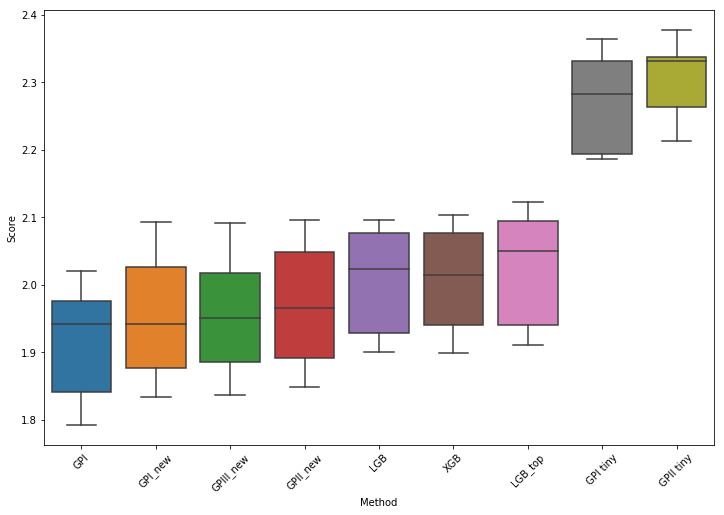

In [14]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame()

try:
    scores_df['LGB'] = scores_lgb
except NameError:
    print('LGB not computed')
try:
    scores_df['LGB_top'] = scores_lgb_top
except NameError:
    print('LGB_top not computed')
try:
    scores_df['LGB_uncorr'] = scores_lgb_uncorr
except NameError:
    print('LGB_uncorr not computed')
try:
    scores_df['LGB_uncorr_top'] = scores_lgb_uncorr_top
except NameError:
    print('LGB_uncorr_top not computed')
try:
    scores_df['XGB'] = scores_xgb
except NameError:
    print('XGB not computed')
try:
    scores_df['GPI'] = scores_gpi
except NameError:
    print('GPI not computed')
try:
    scores_df['GPI_new'] = scores_gpi_new
except NameError:
    print('GPI_new not computed')
try:
    scores_df['GPII_new'] = scores_gpii_new
except NameError:
    print('GPII_new not computed')    
try:
    scores_df['GPIII_new'] = scores_gpiii_new
except NameError:
    print('GPIII_new not computed')     
try:
    scores_df['GPI tiny'] = scores_gpi_tiny
except NameError:
    print('GPI tiny not computed')
try:
    scores_df['GPII tiny'] = scores_gpii_tiny
except NameError:
    print('GPII tiny not computed')
    
ax = sns.boxplot(data=scores_df.reindex(scores_df.mean().sort_values().index, axis=1));
#ax.set(yscale="log")

plt.xticks(rotation=45);
plt.xlabel('Method');
plt.ylabel('Score');

In [ ]:
prediction_blend_gp = (prediction_gpi +
                    prediction_gpi_new + 
                    prediction_gpii_new + 
                    prediction_gpiii_new) / 4
oof_blend_gp = (oof_gpi +
             oof_gpi_new + 
             oof_gpii_new + 
             oof_gpiii_new) / 4

In [ ]:
evaluation = pd.DataFrame(dtype=np.float64)
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_blend_gp
submission.to_csv('../output/submission_blend_gp.csv')

In [ ]:
#dill.dump_session('notebook_env.db')
#dill.load_session('notebook_env.db')